In [1]:
# Step 1: Import pandas
import pandas as pd

# Step 2: Load CSV from URL
url = 'https://raw.githubusercontent.com/egorpol/beat_it/refs/heads/main/csv/dufour_onsets_librosa_unfiltered.csv'
df = pd.read_csv(url)

# Step 3: Display the first few rows of the DataFrame
df.head()


,onset_times
0,0.110295
1,0.400544
2,2.618050
3,4.858776
4,7.082086


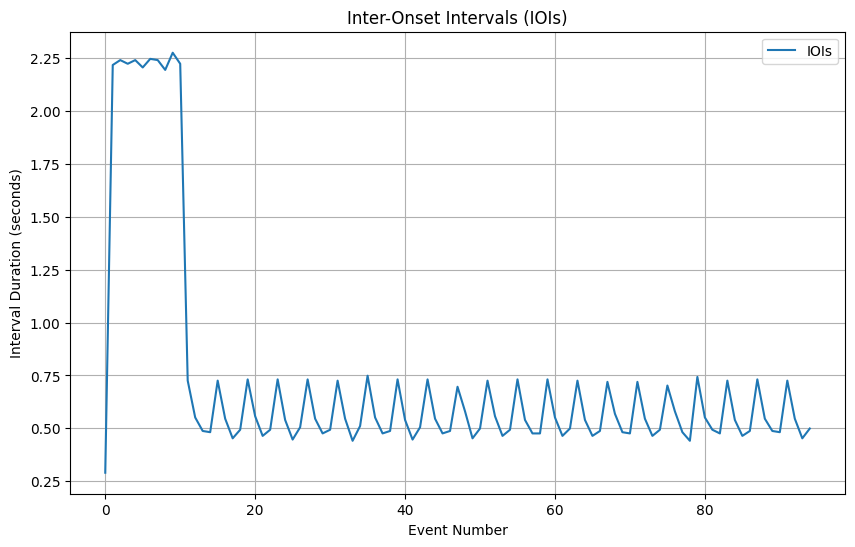

Mean IOI (Average Interval Duration): 0.7317340971476309
Standard Deviation of IOIs: 0.5239414581892734
Coefficient of Variation of IOIs: 0.7160271200039017


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Onset times in seconds
onset_times = df['onset_times'].values

# Calculate inter-onset intervals (IOIs)
iois = np.diff(onset_times)

# Plot the IOIs
plt.figure(figsize=(10, 6))
plt.plot(iois, label="IOIs")
plt.title('Inter-Onset Intervals (IOIs)')
plt.xlabel('Event Number')
plt.ylabel('Interval Duration (seconds)')
plt.grid(True)
plt.legend()
plt.show()

# Calculate standard deviation and coefficient of variation
mean_ioi = np.mean(iois)
std_ioi = np.std(iois)
cv_ioi = std_ioi / mean_ioi  # Coefficient of variation

# Print out results with descriptions
print("Mean IOI (Average Interval Duration):", mean_ioi)
print("Standard Deviation of IOIs:", std_ioi)
print("Coefficient of Variation of IOIs:", cv_ioi)


In [12]:
print(iois)

[0.29024944 2.21750567 2.24072562 2.22331066 2.24072562 2.20589569
 2.24653062 2.24072562 2.19428571 2.27555556 2.22331066 0.72562358
 0.55147392 0.48761905 0.48181406 0.72562358 0.54566894 0.45278911
 0.49342404 0.73142857 0.55727891 0.46439909 0.49342404 0.73142857
 0.53986395 0.44698412 0.50503402 0.73142857 0.54566893 0.47600907
 0.49342404 0.72562358 0.54566894 0.44117913 0.51083901 0.74884353
 0.55147393 0.47600907 0.48761905 0.73142857 0.53986394 0.44698413
 0.50503401 0.73142857 0.54566894 0.47600907 0.48761905 0.69659864
 0.58049886 0.45278912 0.49922902 0.72562359 0.55727891 0.46439909
 0.49342404 0.73142857 0.53986394 0.47600907 0.47600907 0.73142858
 0.55147392 0.46439909 0.49922903 0.72562358 0.53986394 0.4643991
 0.48761905 0.71981859 0.56888889 0.48181406 0.47600907 0.71981859
 0.54566894 0.46439909 0.49342403 0.70240363 0.58049887 0.48181406
 0.44117914 0.74303855 0.55147392 0.49342403 0.47600907 0.72562359
 0.53986394 0.4643991  0.48761904 0.73142858 0.54566893 0.48761

Error (sum of squared residuals): 0.4074363097191211


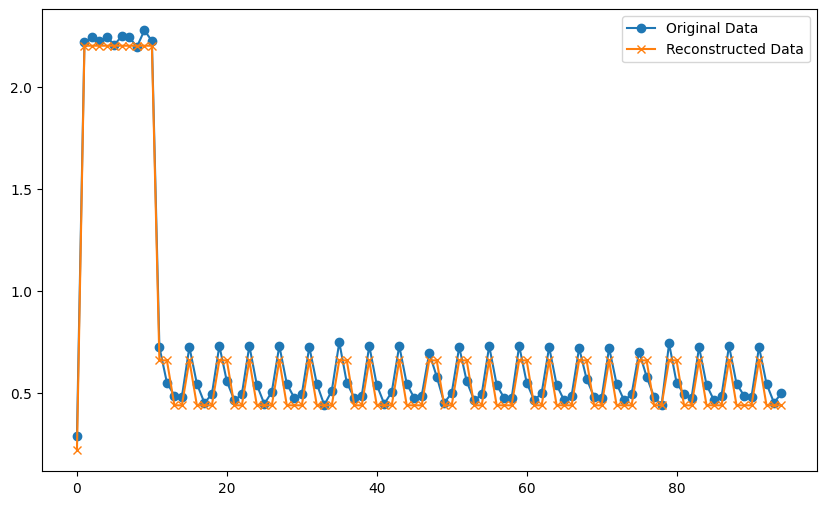

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with actual data)
data = iois

# Custom base value (input your desired base value here)
base_value_custom = 0.22  # Adjust this value as needed

# Calculate multipliers and reconstructed data
multipliers = np.round(data / base_value_custom)
reconstructed_data = base_value_custom * multipliers

# Error calculation (Sum of squared residuals)
residuals = data - reconstructed_data
error = np.sum(residuals**2)

print(f"Error (sum of squared residuals): {error}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data', marker='o')
plt.plot(reconstructed_data, label='Reconstructed Data', marker='x')
plt.legend()
plt.show()


Best base value: 0.02080808080808081
Minimum error: 0.0030118931698300097


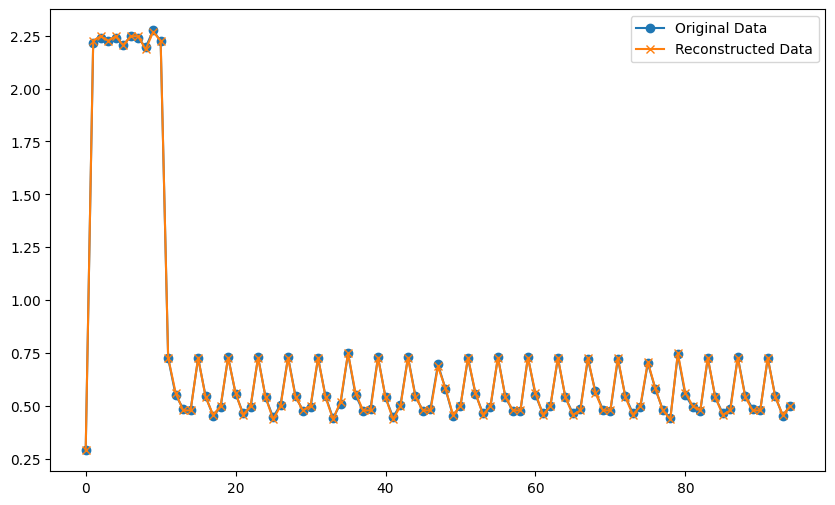

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with actual data)
data = iois

# Define the range for the base value (e.g., 0.1 to 0.25)
base_value_range = np.linspace(0.02, 0.1, 100)  # 100 steps between 0.1 and 0.25

best_base_value = None
min_error = float('inf')

# Grid search for best base value
for base_value in base_value_range:
    multipliers = np.round(data / base_value)
    reconstructed_data = base_value * multipliers
    residuals = data - reconstructed_data
    error = np.sum(residuals**2)
    
    if error < min_error:
        min_error = error
        best_base_value = base_value

print(f"Best base value: {best_base_value}")
print(f"Minimum error: {min_error}")

# Calculate multipliers and reconstructed data using the best base value
multipliers = np.round(data / best_base_value)
reconstructed_data = best_base_value * multipliers

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data', marker='o')
plt.plot(reconstructed_data, label='Reconstructed Data', marker='x')
plt.legend()
plt.show()


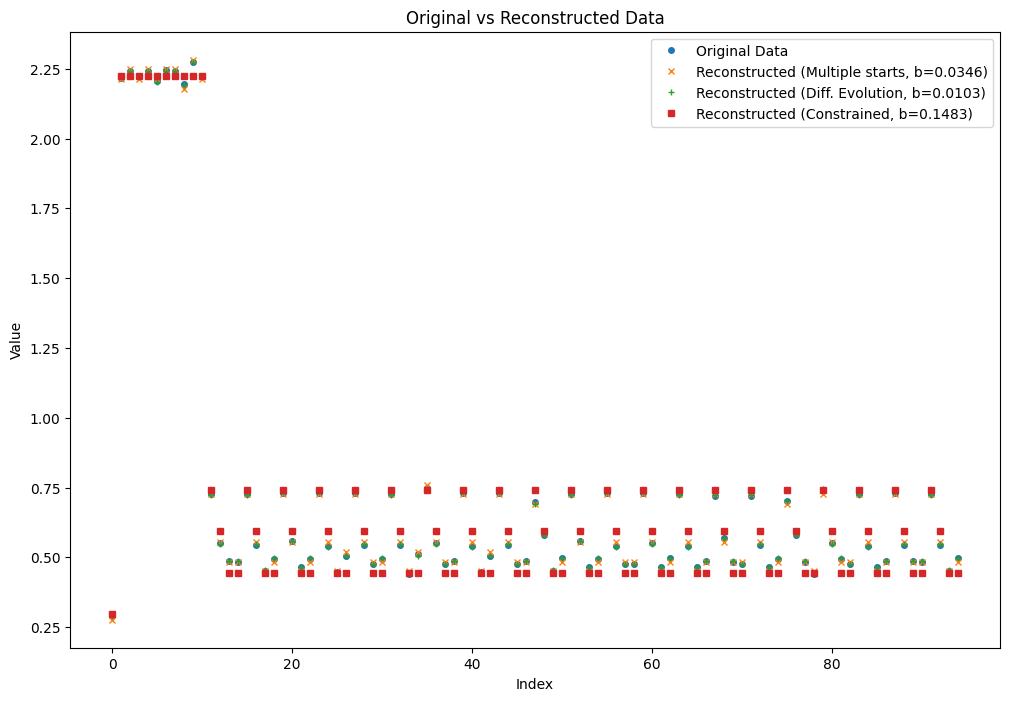

Base value (multiple starts): 0.034580
Base value (differential evolution): 0.010336
Base value (constrained): 0.148311

Error (multiple starts): 0.007182
Error (differential evolution): 0.000581
Error (constrained): 0.113088


In [57]:
import numpy as np
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt

def error_function(b):
    multipliers = np.round(iois / b)
    residuals = iois - b * multipliers
    return np.sum(residuals**2)

# 1. Improve initial guess
base_value_initial = np.min(iois) / 2  # A reasonable starting point

# 2. Try multiple starting points
starting_points = [np.min(iois) / 8, np.min(iois) / 4, np.min(iois) / 2, np.mean(iois) / 5, np.median(iois) / 5]

results = []
for start in starting_points:
    result = minimize(error_function, start, method='Nelder-Mead')
    results.append((result.x[0], result.fun))

best_result = min(results, key=lambda x: x[1])
base_value_optimized = best_result[0]

# 3. Use different optimization algorithm
result_de = differential_evolution(error_function, bounds=[(0.01, 1)])
base_value_de = result_de.x[0]

# 4. Constrain the optimization
def constrained_error_function(b):
    multipliers = np.round(iois / b)
    residuals = iois - b * multipliers
    penalty = 1e6 if b <= 0 else 0  # Large penalty for negative base values
    return np.sum(residuals**2) + penalty

result_constrained = minimize(constrained_error_function, base_value_initial, method='BFGS')
base_value_constrained = result_constrained.x[0]

# Calculate multipliers and reconstructed data for each method
multipliers = np.round(iois / base_value_optimized)
reconstructed_data = base_value_optimized * multipliers

multipliers_de = np.round(iois / base_value_de)
reconstructed_data_de = base_value_de * multipliers_de

multipliers_constrained = np.round(iois / base_value_constrained)
reconstructed_data_constrained = base_value_constrained * multipliers_constrained

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(iois, label='Original Data', marker='o', linestyle='', markersize=4)
plt.plot(reconstructed_data, label=f'Reconstructed (Multiple starts, b={base_value_optimized:.4f})', marker='x', linestyle='', markersize=4)
plt.plot(reconstructed_data_de, label=f'Reconstructed (Diff. Evolution, b={base_value_de:.4f})', marker='+', linestyle='', markersize=4)
plt.plot(reconstructed_data_constrained, label=f'Reconstructed (Constrained, b={base_value_constrained:.4f})', marker='s', linestyle='', markersize=4)
plt.legend()
plt.title('Original vs Reconstructed Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

print(f"Base value (multiple starts): {base_value_optimized:.6f}")
print(f"Base value (differential evolution): {base_value_de:.6f}")
print(f"Base value (constrained): {base_value_constrained:.6f}")

# Calculate and print errors
error_optimized = error_function(base_value_optimized)
error_de = error_function(base_value_de)
error_constrained = error_function(base_value_constrained)

print(f"\nError (multiple starts): {error_optimized:.6f}")
print(f"Error (differential evolution): {error_de:.6f}")
print(f"Error (constrained): {error_constrained:.6f}")

# # Calculate compression ratios
# original_size = iois.nbytes
# compressed_size = multipliers.nbytes + 8  # 8 bytes for the float base value
# compression_ratio = original_size / compressed_size

# print(f"\nCompression ratio: {compression_ratio:.2f}")

Best base value: 0.247748
Minimum error (sum of squared residuals): 0.108485

Detailed Fit Results:


,Original IOI,Multiplier,Reconstructed IOI,Residual
0,0.290249,1,0.247748,0.042502
1,2.217506,9,2.229730,-0.012224
2,2.240726,9,2.229730,0.010996
3,2.223311,9,2.229730,-0.006419
4,2.240726,9,2.229730,0.010996
...,...,...,...,...
90,0.481814,2,0.495495,-0.013681
91,0.725624,3,0.743243,-0.017620
92,0.545669,2,0.495495,0.050173
93,0.452789,2,0.495495,-0.042706


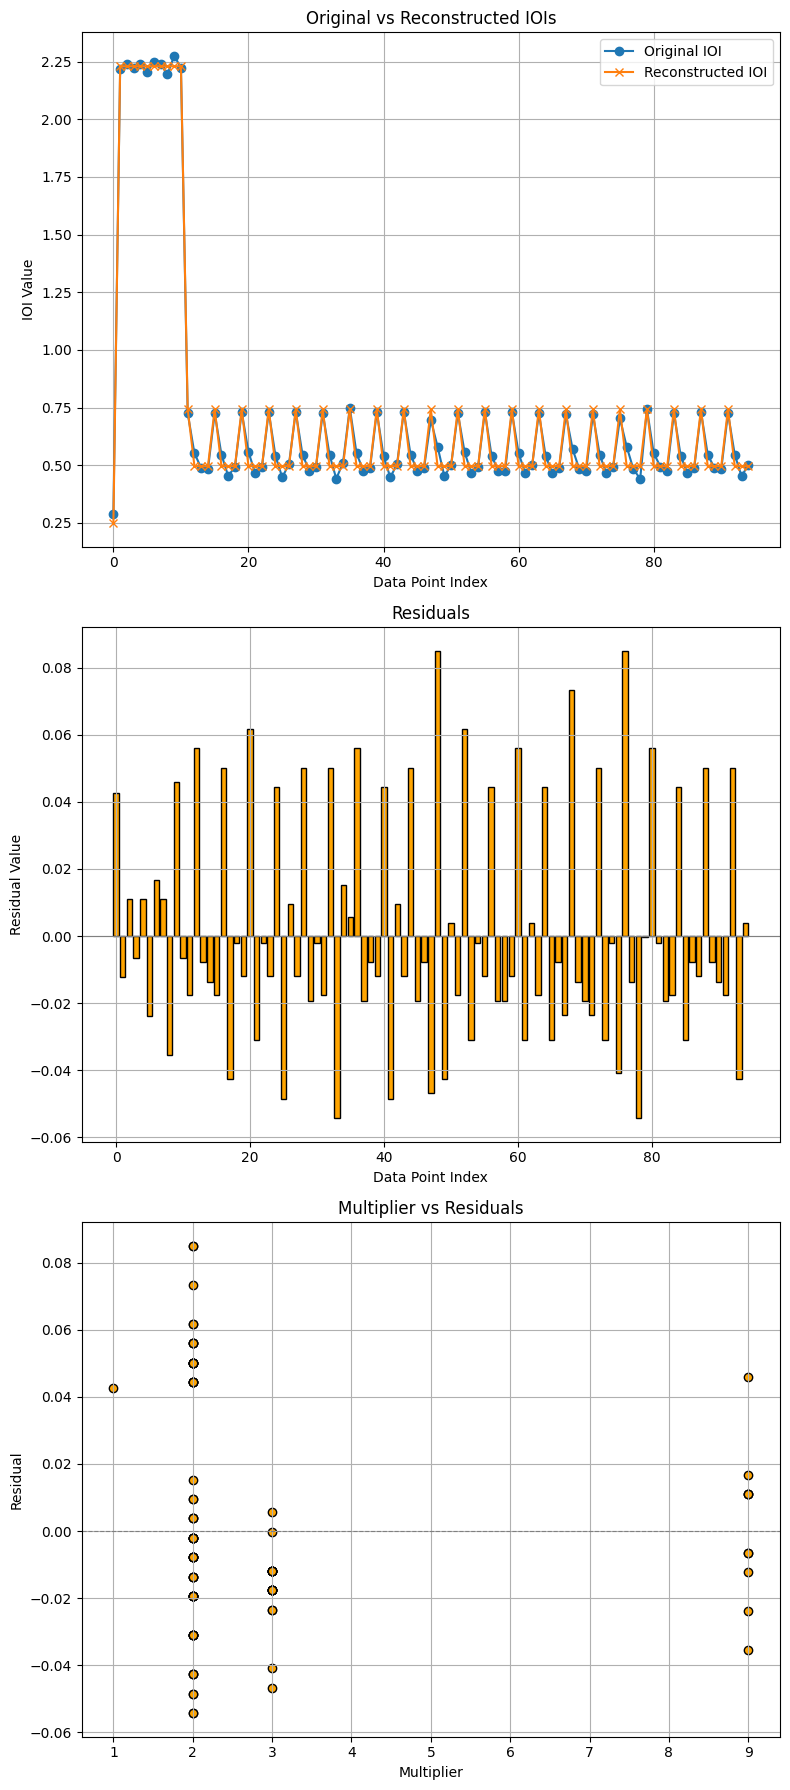

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Replace the following line with your actual 'iois' data
data = iois

# Define the range for the base value (e.g., 0.1 to 0.25)
base_value_range = np.linspace(0.2, 0.3, 1000)  # Increased resolution for finer search

best_base_value = 0.23
min_error = float('inf')

# Grid search for best base value
for base_value in base_value_range:
    multipliers = np.round(data / base_value)
    reconstructed_data = base_value * multipliers
    residuals = data - reconstructed_data
    error = np.sum(residuals**2)
    
    if error < min_error:
        min_error = error
        best_base_value = base_value

print(f"Best base value: {best_base_value:.6f}")
print(f"Minimum error (sum of squared residuals): {min_error:.6f}")

# Calculate multipliers and reconstructed data using the best base value
multipliers = np.round(data / best_base_value)
reconstructed_data = best_base_value * multipliers
residuals = data - reconstructed_data

# Create a DataFrame to display the results
df = pd.DataFrame({
    'Original IOI': data,
    'Multiplier': multipliers.astype(int),
    'Reconstructed IOI': reconstructed_data,
    'Residual': residuals
})

# Display the DataFrame
print("\nDetailed Fit Results:")
display(df)

# Plotting Original vs Reconstructed IOIs and other subplots
plt.figure(figsize=(8, 18))  # Adjust figure size for vertical alignment

# Subplot 1: Original vs Reconstructed IOIs
plt.subplot(3, 1, 1)
plt.plot(data, label='Original IOI', marker='o')
plt.plot(reconstructed_data, label='Reconstructed IOI', marker='x')
plt.title('Original vs Reconstructed IOIs')
plt.xlabel('Data Point Index')
plt.ylabel('IOI Value')
plt.legend()
plt.grid(True)

# Subplot 2: Residuals
plt.subplot(3, 1, 2)
plt.bar(range(len(residuals)), residuals, color='orange', edgecolor='black')
plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Residuals')
plt.xlabel('Data Point Index')
plt.ylabel('Residual Value')
plt.grid(True)

# Subplot 3: Multiplier vs Residuals
plt.subplot(3, 1, 3)
plt.scatter(df['Multiplier'], df['Residual'], color='orange', edgecolor='black')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Adding a line at y=0 for reference
plt.title('Multiplier vs Residuals')
plt.xlabel('Multiplier')
plt.ylabel('Residual')
plt.grid(True)

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()

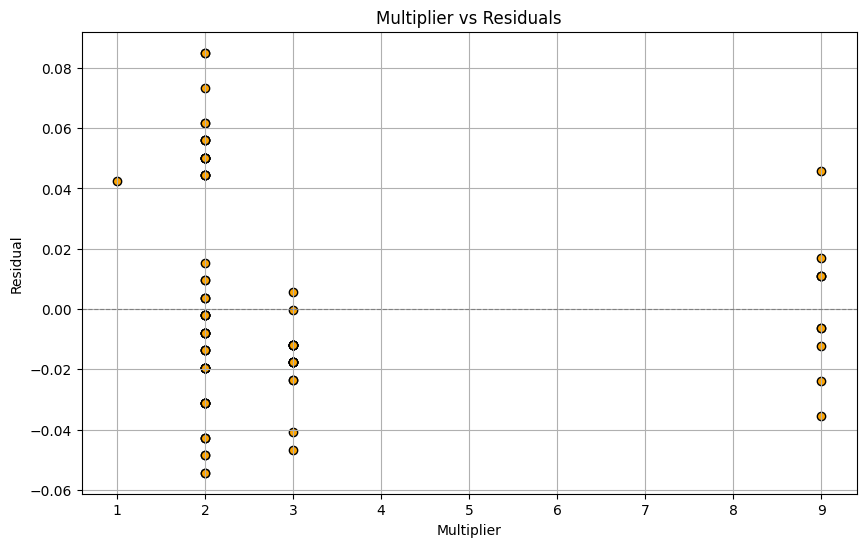

In [70]:
# Ensure you have a DataFrame created with the necessary data
# df = pd.DataFrame({
#     'Original IOI': data,
#     'Multiplier': multipliers.astype(int),
#     'Reconstructed IOI': reconstructed_data,
#     'Residual': residuals
# })

# Plotting Multiplier vs Residual
plt.figure(figsize=(10, 6))
plt.scatter(df['Multiplier'], df['Residual'], color='orange', edgecolor='black')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Adding a line at y=0 for reference
plt.title('Multiplier vs Residuals')
plt.xlabel('Multiplier')
plt.ylabel('Residual')
plt.grid(True)
plt.show()


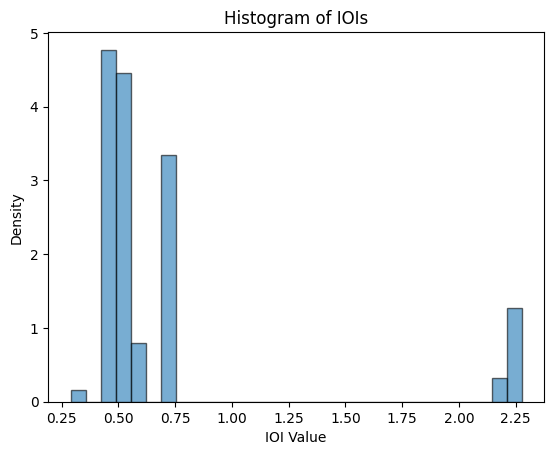

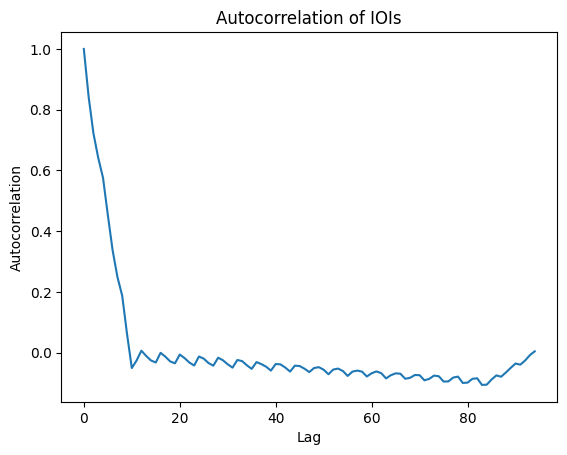

Autocorrelation peaks at lags: []
Histogram peaks at IOI values: [0.45569162 0.7203991 ]


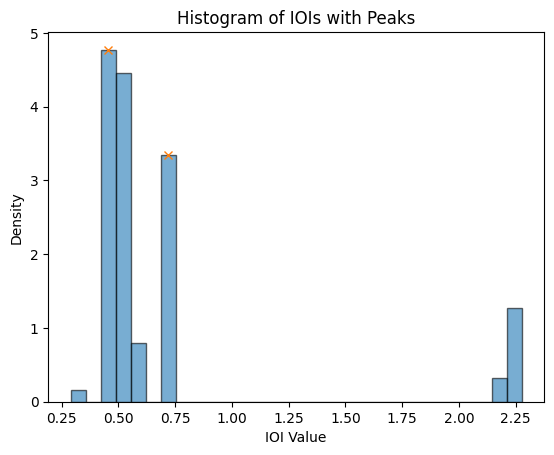

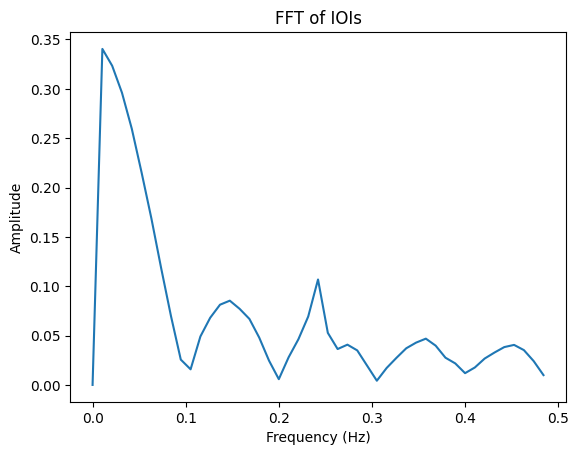

Estimated base unit from FFT: 95.0
First 20 entries with initial base unit:
    Original IOI  Multiplier  Reconstructed IOI  Residual
0       0.290249           1               0.45 -0.159751
1       2.217506           5               2.25 -0.032494
2       2.240726           5               2.25 -0.009274
3       2.223311           5               2.25 -0.026689
4       2.240726           5               2.25 -0.009274
5       2.205896           5               2.25 -0.044104
6       2.246531           5               2.25 -0.003469
7       2.240726           5               2.25 -0.009274
8       2.194286           5               2.25 -0.055714
9       2.275556           5               2.25  0.025556
10      2.223311           5               2.25 -0.026689
11      0.725624           2               0.90 -0.174376
12      0.551474           1               0.45  0.101474
13      0.487619           1               0.45  0.037619
14      0.481814           1               0.45  0.031

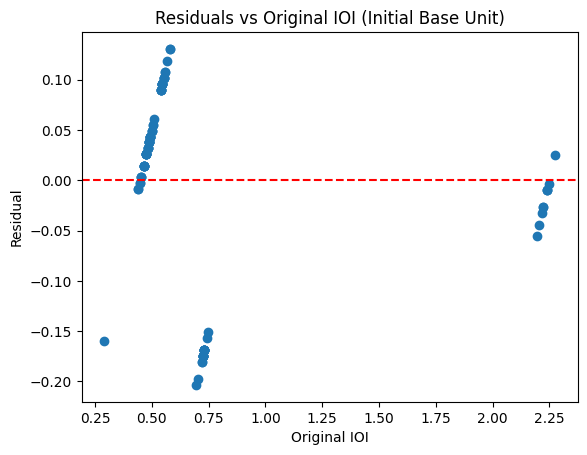


Residual Statistics (Initial):
count    95.000000
mean     -0.007213
std       0.099250
min      -0.203401
25%      -0.038299
50%       0.026009
75%       0.052132
max       0.130499
Name: Residual, dtype: float64
Optimal Base Unit: 0.14831055846067245
First 20 entries with optimized base unit:
    Original IOI  Multiplier  Reconstructed IOI  Residual
0       0.290249           2           0.296621 -0.006372
1       2.217506          15           2.224658 -0.007153
2       2.240726          15           2.224658  0.016067
3       2.223311          15           2.224658 -0.001348
4       2.240726          15           2.224658  0.016067
5       2.205896          15           2.224658 -0.018763
6       2.246531          15           2.224658  0.021872
7       2.240726          15           2.224658  0.016067
8       2.194286          15           2.224658 -0.030373
9       2.275556          15           2.224658  0.050897
10      2.223311          15           2.224658 -0.001348
11     

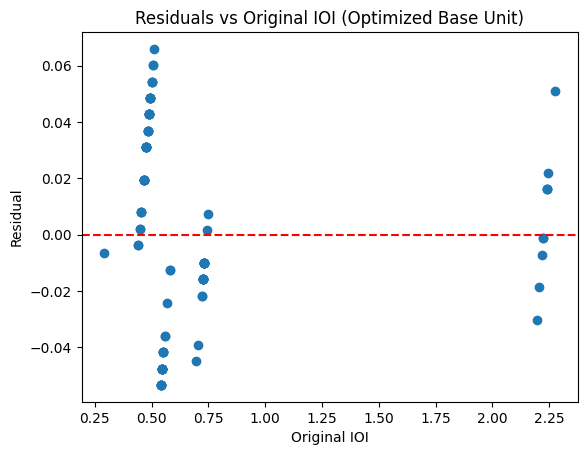


Residual Statistics (Optimized):
count    95.000000
mean      0.002671
std       0.034581
min      -0.053378
25%      -0.020248
50%      -0.001348
75%       0.031077
max       0.065907
Name: Residual, dtype: float64


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.optimize import minimize
import pandas as pd


# Step 1: Visualize Histogram
plt.hist(iois, bins=30, edgecolor='k', alpha=0.6, density=True)
plt.title('Histogram of IOIs')
plt.xlabel('IOI Value')
plt.ylabel('Density')
plt.show()

# Step 2: Autocorrelation
autocorr = np.correlate(iois - np.mean(iois), iois - np.mean(iois), mode='full')
autocorr = autocorr[autocorr.size // 2:]
autocorr /= np.max(autocorr)

plt.plot(autocorr)
plt.title('Autocorrelation of IOIs')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

peaks, _ = find_peaks(autocorr, height=0.5)
print("Autocorrelation peaks at lags:", peaks)

# Step 2: Histogram Peaks
counts, bin_edges = np.histogram(iois, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_peaks, _ = find_peaks(counts, height=np.max(counts)*0.1)
peak_values = bin_centers[hist_peaks]
print("Histogram peaks at IOI values:", peak_values)

plt.hist(iois, bins=30, edgecolor='k', alpha=0.6, density=True)
plt.plot(bin_centers[hist_peaks], counts[hist_peaks], "x")
plt.title('Histogram of IOIs with Peaks')
plt.xlabel('IOI Value')
plt.ylabel('Density')
plt.show()

# Step 2: FFT Analysis
N = len(iois)
T = 1.0  # Adjust if IOIs are in different time units
yf = fft(iois - np.mean(iois))
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('FFT of IOIs')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

peak_freq = xf[np.argmax(2.0/N * np.abs(yf[0:N//2]))]
base_unit_fft = 1 / peak_freq if peak_freq != 0 else None
print("Estimated base unit from FFT:", base_unit_fft)

# Step 4: Initial Quantization with Example Base Unit
initial_b = 0.45  # Example; adjust based on earlier analysis
multipliers = np.round(iois / initial_b).astype(int)
reconstructed_iois = multipliers * initial_b
residuals = iois - reconstructed_iois

df = pd.DataFrame({
    'Original IOI': iois,
    'Multiplier': multipliers,
    'Reconstructed IOI': reconstructed_iois,
    'Residual': residuals
})

print("First 20 entries with initial base unit:")
print(df.head(20))

plt.scatter(df['Original IOI'], df['Residual'])
plt.title('Residuals vs Original IOI (Initial Base Unit)')
plt.xlabel('Original IOI')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--')
plt.show()

print("\nResidual Statistics (Initial):")
print(df['Residual'].describe())

# Step 6: Optimize Base Unit
def objective(b):
    if b <= 0:
        return np.inf
    m = np.round(iois / b)
    reconstructed = m * b
    return np.sum((iois - reconstructed) ** 2)

result = minimize(objective, initial_b, bounds=[(0.1, 1.0)])
optimal_b = result.x[0]
print("Optimal Base Unit:", optimal_b)

# Recompute with optimal base unit
multipliers_opt = np.round(iois / optimal_b).astype(int)
reconstructed_iois_opt = multipliers_opt * optimal_b
residuals_opt = iois - reconstructed_iois_opt

df_opt = pd.DataFrame({
    'Original IOI': iois,
    'Multiplier': multipliers_opt,
    'Reconstructed IOI': reconstructed_iois_opt,
    'Residual': residuals_opt
})

print("First 20 entries with optimized base unit:")
print(df_opt.head(20))

plt.scatter(df_opt['Original IOI'], df_opt['Residual'])
plt.title('Residuals vs Original IOI (Optimized Base Unit)')
plt.xlabel('Original IOI')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--')
plt.show()

print("\nResidual Statistics (Optimized):")
print(df_opt['Residual'].describe())


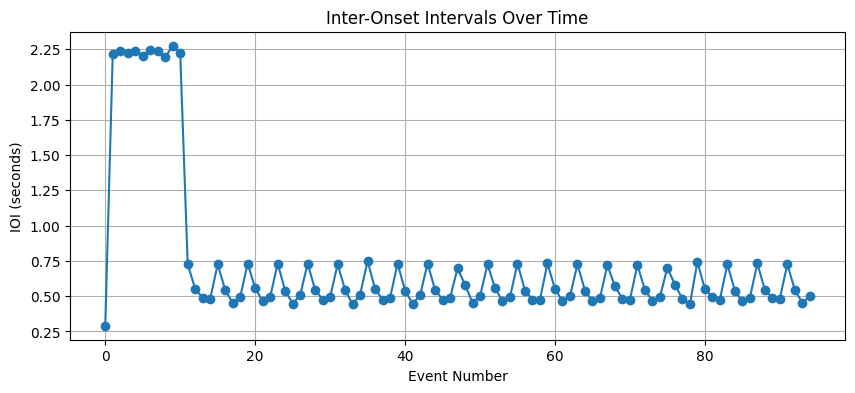

In [8]:
mean_ioi = np.mean(iois)
sd_ioi = np.std(iois, ddof=1)
cv_ioi = sd_ioi / mean_ioi

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(iois, marker='o')
plt.title('Inter-Onset Intervals Over Time')
plt.xlabel('Event Number')
plt.ylabel('IOI (seconds)')
plt.grid(True)
plt.show()



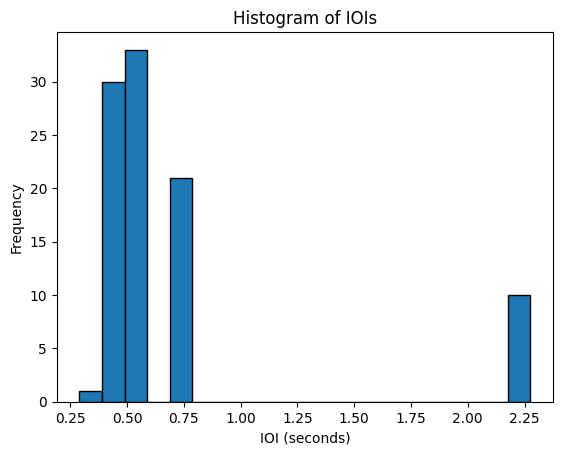

In [9]:
plt.hist(iois, bins=20, edgecolor='black')
plt.title('Histogram of IOIs')
plt.xlabel('IOI (seconds)')
plt.ylabel('Frequency')
plt.show()


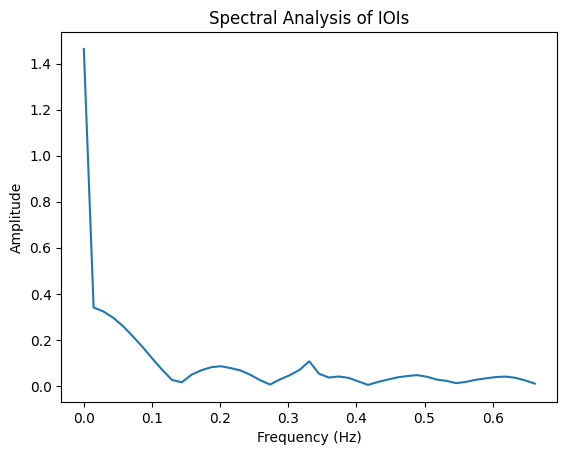

In [11]:
from scipy.fft import fft, fftfreq

N = len(iois)
T = np.mean(iois)
yf = fft(iois)
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('Spectral Analysis of IOIs')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()


In [4]:
import numpy as np

global_pulse = np.median(iois)
print(f"Estimated Global Pulse: {global_pulse} seconds")


Estimated Global Pulse: 0.5398639500000009 seconds


In [5]:
# Create a pulse grid (aligned to the first onset)
pulse_grid = np.arange(onset_times[0], onset_times[-1], global_pulse)

# For each onset time, find the nearest pulse
deviations = np.array([min(abs(onset_times - pulse)) for pulse in pulse_grid])

# Calculate the deviation of each peak from the grid


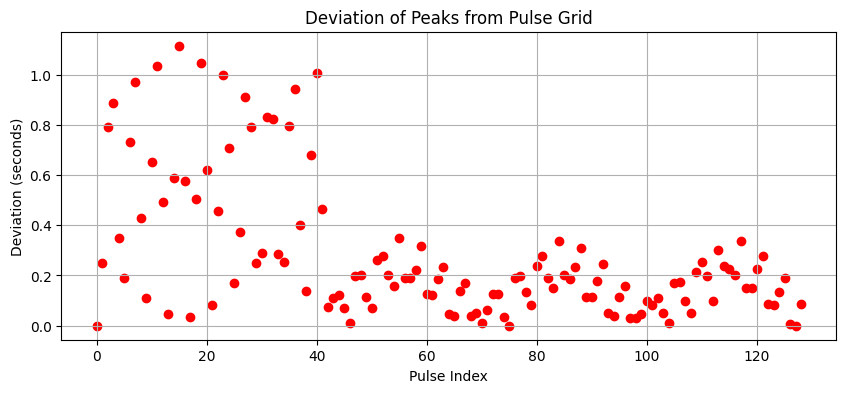

In [6]:
plt.figure(figsize=(10, 4))
plt.scatter(np.arange(len(deviations)), deviations, color='red')
plt.title('Deviation of Peaks from Pulse Grid')
plt.xlabel('Pulse Index')
plt.ylabel('Deviation (seconds)')
plt.grid(True)
plt.show()
